# ConvNextTiny no Fine tuning

Results>

Best Epoch: 94

test acc: 0.85016

test loss: 3.0062

f1_score: 0.85129

Precision: 0.8406

Recall: 0.86225

ROC AUC: 0.84987

---Training 100 Epochs:  seconds --- 24051 s

---Inferense (6000 images):  seconds --- 51.29 s

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install torchvision

In [4]:

#!pip list
import torch

In [5]:
#!nvidia-smi

In [6]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [7]:
# add headings with ##(space) on the markdowns

In [8]:
#!pip install tensorflor keras

In [9]:
import tensorflow as tf
import os

In [10]:
!nvidia-smi

Tue Jun 25 15:50:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   49C    P8              16W / 125W |    943MiB /  6144MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
#! nvidia-smi

In [14]:
#!pip install opencv-python

## Imports

In [15]:
import tensorflow as tf
import os
import cv2
import imghdr

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
class TrainingConfig:
    BATCH_SIZE:       int   = 64
    EPOCHS:           int   = 100
    LEARNING_RATE:    float = 0.001
    DROPOUT:          float = 0.5
    LAYERS_FINE_TUNE: int   = 0
    EPSILON:          float = 1e-07
    MOMENTUM:         float = 0.9   
    WEIGHT_DECAY:     float = 0.0005 

# Split Data

In [18]:
base_dir = r"C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\READY_BALANCED_SAME_SIZE_Random_Split"

In [19]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [20]:
train_Ads_dir = os.path.join(train_dir, 'Ads')
train_sample_dir = os.path.join(train_dir, 'Sample')
train_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\train\\Ads'

In [21]:
validation_Ads_dir = os.path.join(validation_dir, 'Ads')
validation_sample_dir = os.path.join(validation_dir, 'Sample')
validation_Ads_dir


'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\validation\\Ads'

In [22]:
test_Ads_dir = os.path.join(test_dir, 'Ads')
test_sample_dir = os.path.join(test_dir, 'Sample')
test_Ads_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\READY_BALANCED_SAME_SIZE_Random_Split\\test\\Ads'

In [23]:
print('total training Ads images:', len(os.listdir(train_Ads_dir)))

total training Ads images: 10500


In [24]:
print('total training sample images:', len(os.listdir(train_sample_dir)))

total training sample images: 10500


In [25]:
print('total validation Ads images:', len(os.listdir(validation_Ads_dir)))

total validation Ads images: 3650


In [26]:
print('total validation sample images:', len(os.listdir(validation_sample_dir)))

total validation sample images: 3950


In [27]:
print('total test Ads images:', len(os.listdir(test_Ads_dir)))

total test Ads images: 3000


In [28]:
print('total test sample images:', len(os.listdir(test_sample_dir)))

total test sample images: 3000


## Using data augmentation/ datagen

In [29]:
import numpy as np
from PIL import ImageEnhance
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator  
from tensorflow.keras.utils import img_to_array, array_to_img,  load_img

In [30]:
# Custom preprocessing function for color augmentation
def color_jitter(image):
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.4, 1.6)) # from -60% to +60%
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.4, 1.6))
    image = ImageEnhance.Color(image).enhance(np.random.uniform(0.4, 1.6))
    return image

In [31]:
# Custom preprocessing function for ImageDataGenerator
def custom_preprocessing_function(image):
    # Convert array to PIL image
    image = array_to_img(image)
    # Apply color jitter
    image = color_jitter(image)
    # Convert PIL image back to array
    image = img_to_array(image)
    return image

In [32]:
from keras.preprocessing.image import ImageDataGenerator
## with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing_function)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.BATCH_SIZE,
        class_mode='binary')

Found 21000 images belonging to 2 classes.
Found 7600 images belonging to 2 classes.


## Pretrained Model Inception

In [33]:
import keras
from keras.models import load_model


# Appling a Pre-trained CNN on our Dataset for comparison

The MobileNet model




In [34]:
from keras.applications import ConvNeXtTiny

conv_base = ConvNeXtTiny(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))

In [35]:
conv_base.summary()


Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 56, 56, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']         

We will add a dense layer after our conv_base NN

In [36]:
from keras import models
from keras import layers
from keras.regularizers import l2, l1
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D

modelPreTConvNTiny = models.Sequential()
modelPreTConvNTiny.add(conv_base)

modelPreTConvNTiny.add(layers.Flatten())
modelPreTConvNTiny.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
modelPreTConvNTiny.add(BatchNormalization())
modelPreTConvNTiny.add(layers.Dropout(TrainingConfig.DROPOUT))
modelPreTConvNTiny.add(layers.Dense(1, activation='sigmoid'))

In [37]:
modelPreTConvNTiny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 256)               9634048   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [38]:
# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(conv_base.layers)

In [39]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(modelPreTConvNTiny.trainable_weights))

This is the number of trainable weights before freezing the conv base: 186


In [40]:
# Freeze the initial layers in the convolutional base.
for model_layer in conv_base.layers[:num_layers - num_layers_fine_tune]:
    #print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

In [41]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 convnext_tiny_prestem_normalization False
2 convnext_tiny_stem False
3 convnext_tiny_stage_0_block_0_depthwise_conv False
4 convnext_tiny_stage_0_block_0_layernorm False
5 convnext_tiny_stage_0_block_0_pointwise_conv_1 False
6 convnext_tiny_stage_0_block_0_gelu False
7 convnext_tiny_stage_0_block_0_pointwise_conv_2 False
8 convnext_tiny_stage_0_block_0_layer_scale False
9 convnext_tiny_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_tiny_stage_0_block_1_depthwise_conv False
12 convnext_tiny_stage_0_block_1_layernorm False
13 convnext_tiny_stage_0_block_1_pointwise_conv_1 False
14 convnext_tiny_stage_0_block_1_gelu False
15 convnext_tiny_stage_0_block_1_pointwise_conv_2 False
16 convnext_tiny_stage_0_block_1_layer_scale False
17 convnext_tiny_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_tiny_stage_0_block_2_depthwise_conv False
20 convnext_tiny_stage_0_block_2_layernorm False
21 convnext_tiny_stage_0_block_2_pointw

In [42]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(modelPreTConvNTiny.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [43]:
modelPreTConvNTiny.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 256)               9634048   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [44]:
from keras import optimizers
adagrad = optimizers.Adagrad(learning_rate=TrainingConfig.LEARNING_RATE, initial_accumulator_value=0.1, epsilon=TrainingConfig.EPSILON, decay =TrainingConfig.WEIGHT_DECAY)

In [45]:
modelPreTConvNTiny.compile(optimizer= adagrad, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])# Adagrad, adam

In [46]:
# add checkpoint to store the model on the best epoch for Val acc.
checkpoint_filepath = r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelConvNextTiny_FT0-{epoch:02d}-{val_accuracy:.4f}.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [47]:
print(TrainingConfig.EPOCHS)

100


In [58]:
import time
start_time = time.time()

In [49]:
histPreT = modelPreTConvNTiny.fit(train_generator, epochs=TrainingConfig.EPOCHS, validation_data=validation_generator, callbacks=[model_checkpoint_callback]) #  epochs 10 are over fitting. early stop at?

Epoch 1/100
329/329 [==============================] - ETA: 0s - loss: 5.6168 - accuracy: 0.6769
Epoch 1: val_accuracy improved from -inf to 0.80750, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelConvNextTiny_FT0-01-0.8075.keras
329/329 [==============================] - 272s 794ms/step - loss: 5.6168 - accuracy: 0.6769 - val_loss: 5.3183 - val_accuracy: 0.8075
Epoch 2/100
329/329 [==============================] - ETA: 0s - loss: 5.3856 - accuracy: 0.7164
Epoch 2: val_accuracy did not improve from 0.80750
329/329 [==============================] - 237s 720ms/step - loss: 5.3856 - accuracy: 0.7164 - val_loss: 5.2544 - val_accuracy: 0.7518
Epoch 3/100
329/329 [==============================] - ETA: 0s - loss: 5.2255 - accuracy: 0.7224
Epoch 3: val_accuracy improved from 0.80750 to 0.83895, saving model to C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints\modelConvNextTiny_FT0-03-0.8389.keras
329/329 [==============================] - 240s 729

In [50]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 24051.5261824131 seconds ---


In [51]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [52]:
os.path.join(Current_dir, 'History')

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History'

In [53]:
import pickle
with open(r'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\History\\HistoryDict_ConvNextTiny_FT0', 'wb') as file_pi:
    pickle.dump(histPreT.history, file_pi)

In [54]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 94


In [55]:
START_PLOT_FROM_EPOCH= 1

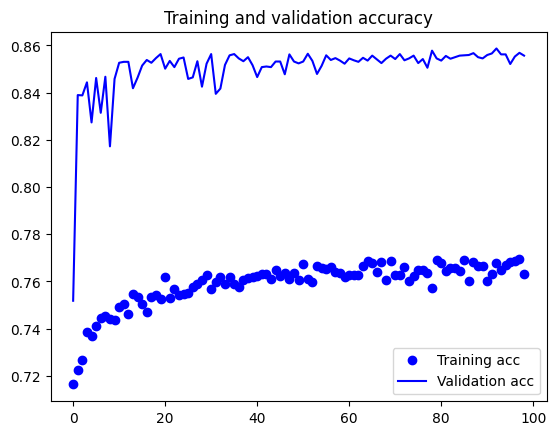

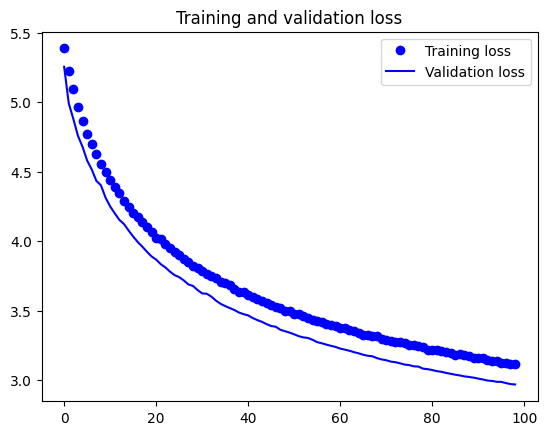

In [56]:
acc = histPreT.history['accuracy'][START_PLOT_FROM_EPOCH:]
val_acc = histPreT.history['val_accuracy'][START_PLOT_FROM_EPOCH:]
loss = histPreT.history['loss'][START_PLOT_FROM_EPOCH:]
val_loss = histPreT.history['val_loss'][START_PLOT_FROM_EPOCH:]

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [57]:
val_acc_per_epoch = histPreT.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 94


# Loading best epoch in our model using the checkpoints

In [48]:
model_dir= r'C:\Users\YannisPC\PycharmProjects\Thesis\Thesis\checkpoints' 

In [49]:
best_val_accuracy = max(val_acc_per_epoch)
best_model_file = f'model-{best_epoch:02d}-{best_val_accuracy:.4f}.keras'

print(f'Best model file: {best_model_file}')

NameError: name 'val_acc_per_epoch' is not defined

In [50]:
# Construct the full path to the best model file
best_model_path = os.path.join(model_dir, best_model_file)
best_model_path

NameError: name 'best_model_file' is not defined

In [51]:
os.chdir(model_dir)
Current_dir = os.getcwd()
Current_dir

'C:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis\\checkpoints'

In [52]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(model_dir) if isfile(join(model_dir, f))]
onlyfiles

['checkpoints.lnk',
 'ConvNextTiny_FT10-01-0.7364.keras',
 'ConvNextTiny_FT10-02-0.8338.keras',
 'ConvNextTiny_FT10-04-0.8345.keras',
 'ConvNextTiny_FT10-06-0.8470.keras',
 'ConvNextTiny_FT10-08-0.8511.keras',
 'ConvNextTiny_FT10-10-0.8541.keras',
 'ConvNextTiny_FT10-22-0.8542.keras',
 'ConvNextTiny_FT10-27-0.8543.keras',
 'ConvNextTiny_FT10-31-0.8563.keras',
 'ConvNextTiny_FT10-33-0.8572.keras',
 'ConvNextTiny_FT10-39-0.8575.keras',
 'ConvNextTiny_FT10-42-0.8582.keras',
 'ConvNextTiny_FT10-44-0.8584.keras',
 'modelConvNextTiny_FT0-01-0.8075.keras',
 'modelConvNextTiny_FT0-03-0.8389.keras',
 'modelConvNextTiny_FT0-05-0.8443.keras',
 'modelConvNextTiny_FT0-07-0.8462.keras',
 'modelConvNextTiny_FT0-09-0.8467.keras',
 'modelConvNextTiny_FT0-12-0.8526.keras',
 'modelConvNextTiny_FT0-13-0.8530.keras',
 'modelConvNextTiny_FT0-18-0.8538.keras',
 'modelConvNextTiny_FT0-20-0.8546.keras',
 'modelConvNextTiny_FT0-21-0.8563.keras',
 'modelConvNextTiny_FT0-53-0.8564.keras',
 'modelConvNextTiny_FT0-

In [53]:
class LayerScale(layers.Layer):
    """Layer scale module.

    References:
      - https://arxiv.org/abs/2103.17239

    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.

    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

In [54]:
from keras.models import load_model
#loaded_model = load_model(os.path.join('checkpoints',best_model_file))
loaded_model = load_model('modelConvNextTiny_FT0-94-0.8587.keras', custom_objects={"LayerScale": LayerScale }) #
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 7, 7, 768)         27820128  
                                                                 
 flatten (Flatten)           (None, 37632)             0         
                                                                 
 dense (Dense)               (None, 256)               9634048   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

## Evaluate

In [59]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [60]:
start_time = time.time()

In [61]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=TrainingConfig.EPOCHS,
        class_mode='binary')

test_loss, test_acc = loaded_model.evaluate(test_generator, steps=len(test_generator))  # steps_per_epoch * epochs
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 6000 images belonging to 2 classes.
60/60 [==============================] - 51s 730ms/step - loss: 3.0063 - accuracy: 0.8502
test acc: 0.8501666784286499
test loss: 3.006267547607422


In [62]:
print("--- %s Training set > seconds ---" % (time.time() - start_time))

--- 51.291699171066284 Training set > seconds ---


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize lists to collect true labels and predictions
true_labels = []
predicted_labels = []

In [75]:
for _ in range(len(test_generator)):
    X, y = next(test_generator)

    yhat = loaded_model.predict(X)
    
    y_true_batch = y # Labels
    
    # Convert probabilities to class labels using a threshold of 0.5
    y_pred_batch = (yhat > 0.5).astype(int)

    # Append the true labels and predictions for this batch to the lists
    true_labels.extend(y_true_batch)
    predicted_labels.extend(y_pred_batch)

    if len(true_labels) >= test_generator.n:
        break

4/4 [==============================] - 1s 175ms/step


In [76]:
# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [77]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[2520,  489],
       [ 412, 2579]], dtype=int64)

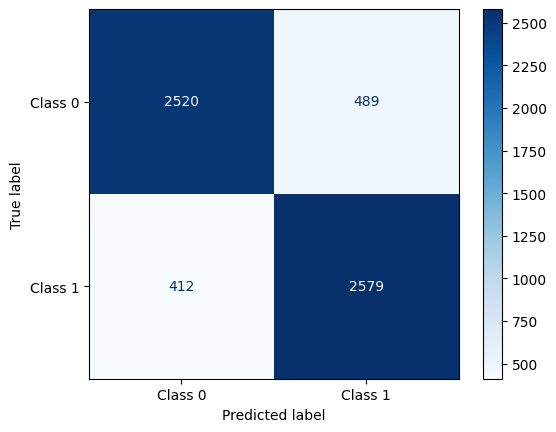

In [78]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [79]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [80]:
f1_score(true_labels, predicted_labels)

0.8512955933322329

In [81]:
# precision tp / (tp + fp)
precision = precision_score(true_labels, predicted_labels)
precision

0.840612777053455

In [82]:
# recall: tp / (tp + fn)
recall = recall_score(true_labels, predicted_labels)
recall

0.8622534269475092

In [83]:
# ROC AUC
auc = roc_auc_score(true_labels, predicted_labels)
print('ROC AUC: %f' % auc)

ROC AUC: 0.849870
